In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as graph
import seaborn as sns

from pprint import pprint

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score

from rosey.graphing import plot_ecdf

graph.style.use('fivethirtyeight')

/home/stephen/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('data/educater/education-income-train.csv')

# Prep data
train.dropna(inplace=True)

encoder_gender = LabelEncoder().fit(train['sex'])
encoder_marital = LabelEncoder().fit(train['marital'])

display(train.head())
print(train.shape)

,income,height,weight,age,marital,sex,education,afqt
0,19000,60,155.0,53,married,female,13.0,6.841
1,35000,70,156.0,51,married,female,10.0,49.444
2,105000,65,195.0,52,married,male,16.0,99.393
3,40000,63,197.0,54,married,female,14.0,44.022
4,75000,66,190.0,49,married,male,14.0,59.683


(5715, 8)


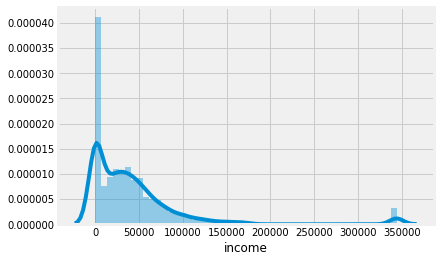

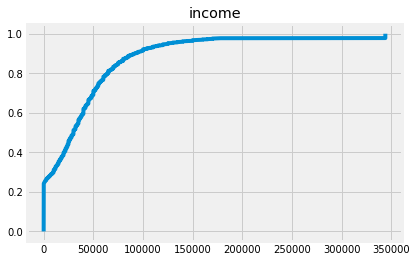

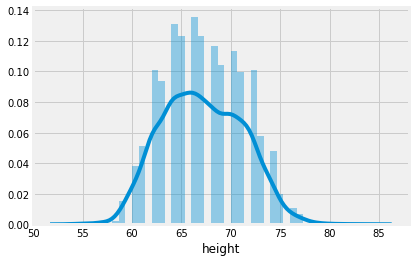

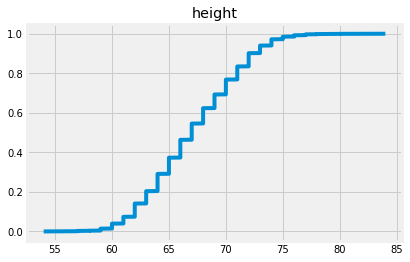

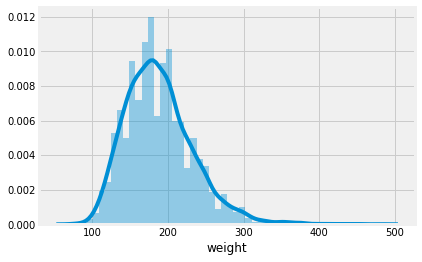

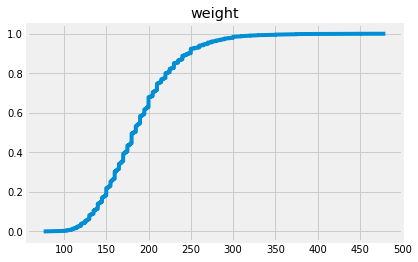

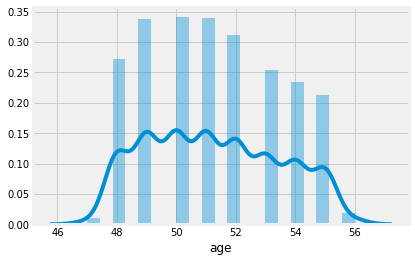

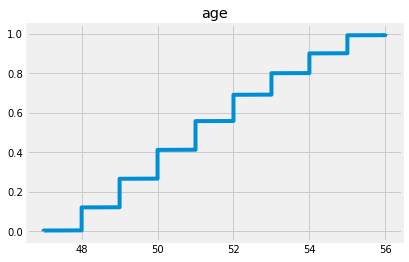

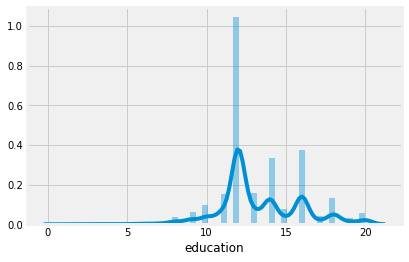

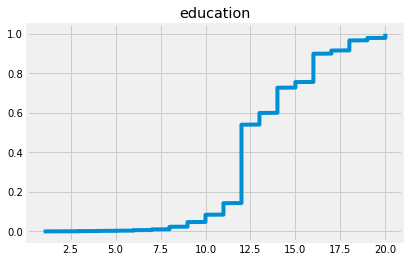

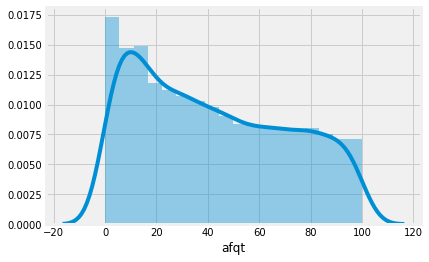

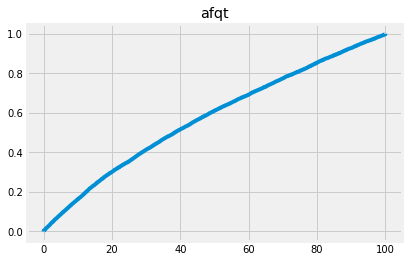

In [3]:
for feature in ['income', 'height', 'weight', 'age', 'education', 'afqt']:
    sns.distplot(train[feature])
    graph.show()
    
    graph.title(feature)
    plot_ecdf(train[feature])
    graph.show()

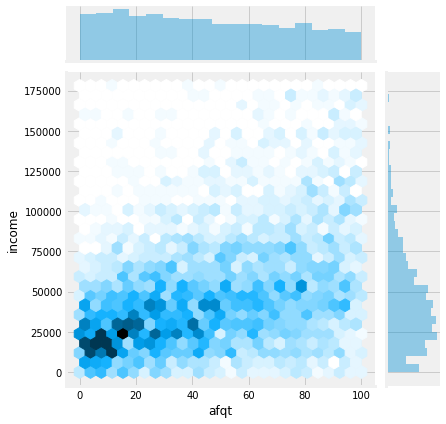

In [4]:
sns.jointplot(x='afqt', y='income', kind='hex', data=train.query('income > 0 & income < 325000'))
graph.show()

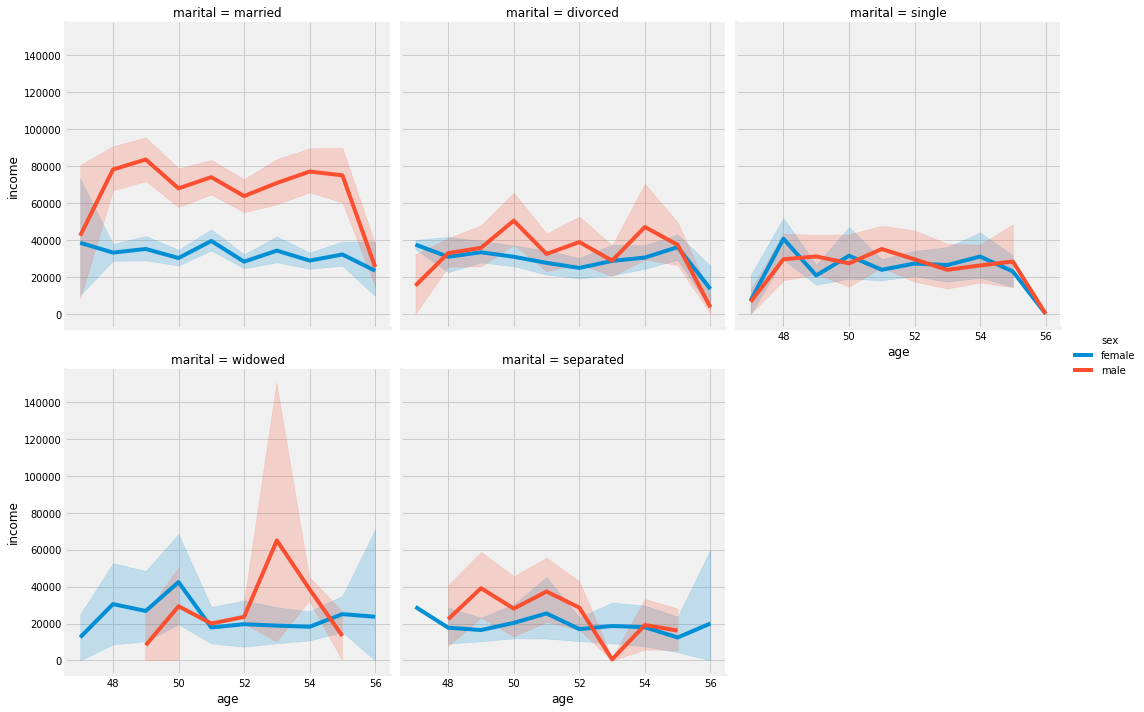

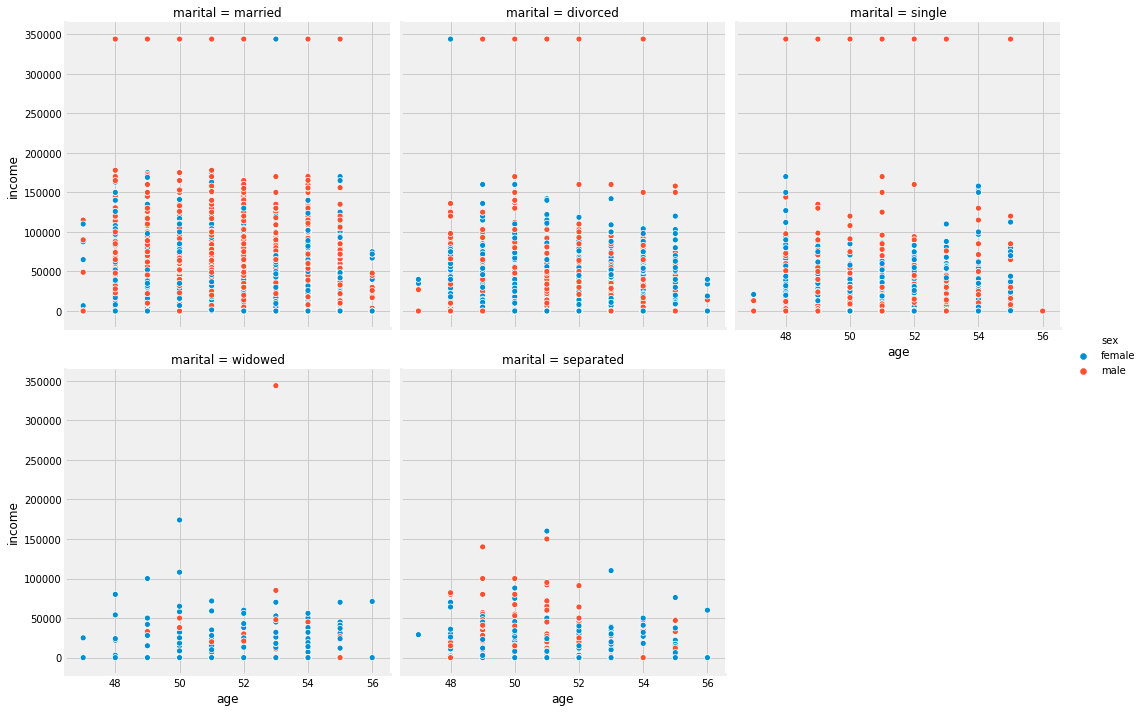

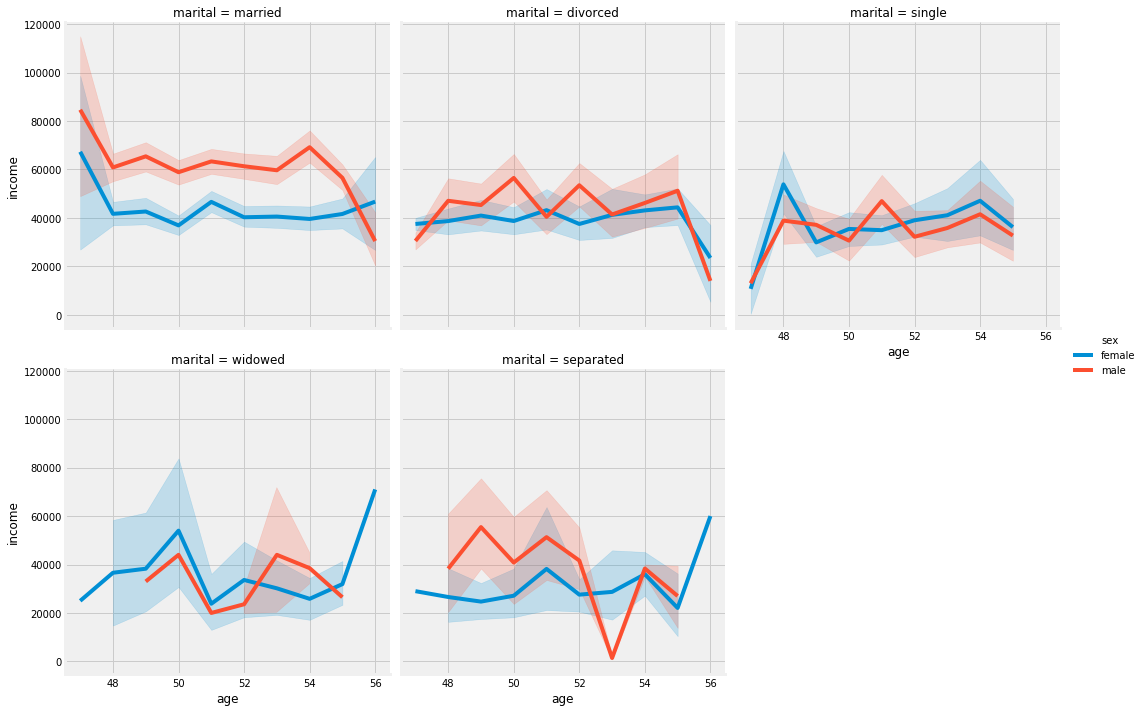

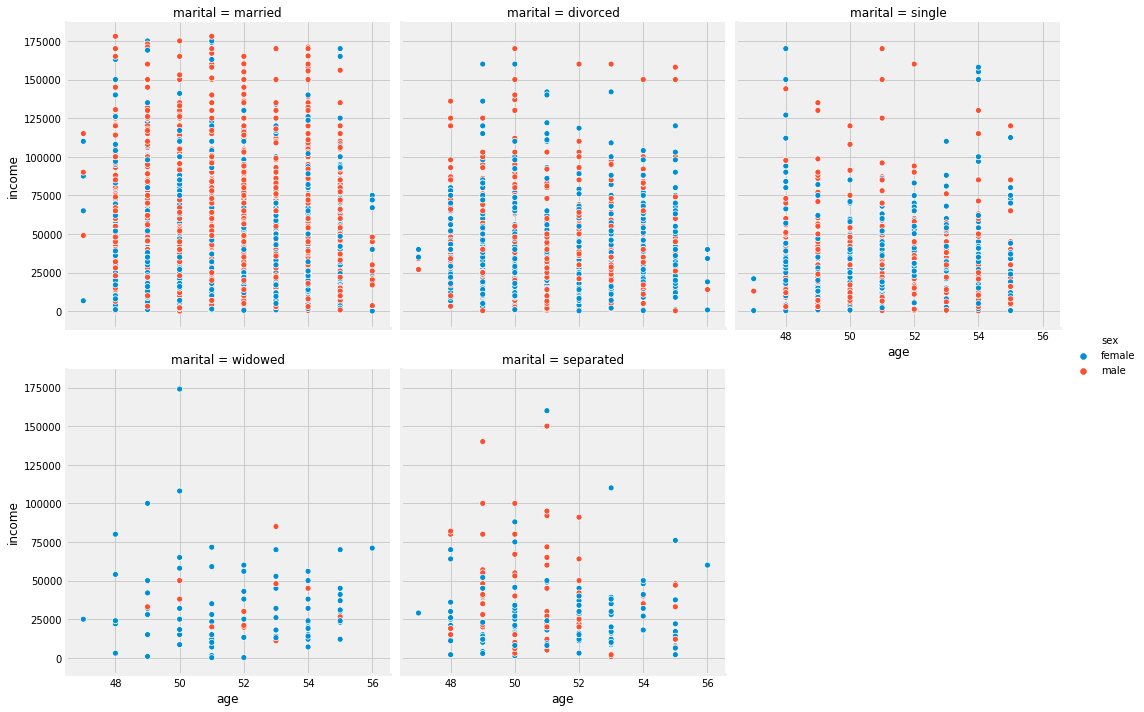

In [5]:
sns.relplot(x='age', y='income', hue='sex', col='marital', data=train, kind='line', col_wrap=3)
graph.show()

sns.relplot(x='age', y='income', hue='sex', col='marital', data=train, col_wrap=3)
graph.show()

# No zeros or ceilings
sns.relplot(
    x='age', y='income', hue='sex', col='marital', 
    data=train.query('income > 0 & income < 325000'), kind='line', col_wrap=3
)
graph.show()

sns.relplot(
    x='age', y='income', hue='sex', col='marital', 
    data=train.query('income > 0 & income < 325000'), col_wrap=3
)
graph.show()

# Model

In [6]:
def create_xy(df):
    target = df.pop('income').values
    df['sex'] = encoder_gender.transform(df['sex'])
    df['marital'] = encoder_marital.transform(df['marital'])
    return df.values, target

In [7]:
x, y = create_xy(train.copy())

print(x.shape, y.shape)

(5715, 7) (5715,)


In [8]:
%%time
# Grid Search
grid_search = GridSearchCV(
    DecisionTreeRegressor(min_samples_leaf=5),
    {
        'min_samples_split': [5, 10, 25, 50, 100, 250, 500, 1000, 1500, 2000],
        'max_depth': [1, 3, 5, 10, 20, 50, 75, 100, 200]
    },
    n_jobs=-1,
    cv=20,
    verbose=1
)
grid_search.fit(x, y)

print('Rsq', grid_search.best_score_)

Fitting 20 folds for each of 90 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    0.6s


Rsq 0.25618966218401584
CPU times: user 834 ms, sys: 83.4 ms, total: 918 ms
Wall time: 2.99 s


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:    2.8s finished


{'afqt': 0.18682528580336613,
 'age': 0.002213975543059312,
 'education': 0.48512987955544956,
 'height': 0.0006151629979578966,
 'marital': 0.0343748051768472,
 'sex': 0.26065182369633394,
 'weight': 0.030189067226985954}


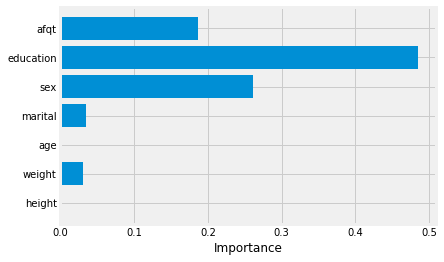

In [9]:
importances = {k: v for k, v in zip(train.columns[1:], grid_search.best_estimator_.feature_importances_)}

pprint(importances)

graph.barh(range(len(importances.values())), list(importances.values()), tick_label=list(importances.keys()))
graph.xlabel('Importance')
graph.show()

{'max_depth': 20, 'min_samples_split': 250}


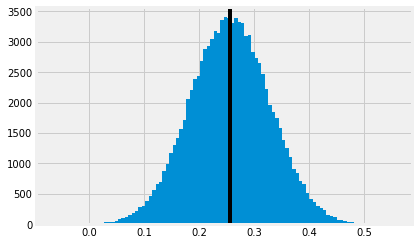

CPU times: user 382 ms, sys: 231 ms, total: 612 ms
Wall time: 311 ms


In [10]:
%%time
print(grid_search.best_params_)

basic_scores = cross_val_score(
    grid_search.best_estimator_, 
    x, y, 
    cv=20
)

graph.hist(stats.norm(basic_scores.mean(), basic_scores.std()).rvs(100000), bins=100)
graph.axvline(grid_search.best_score_, color='black')
graph.show()

# Out of Sample Performance

In [11]:
test = pd.read_csv('data/educater/education-income-test.csv')
test.dropna(inplace=True)

x_test, y_test = create_xy(test)

print(x_test.shape, y_test.shape)

(930, 7) (930,)


In [12]:
print('Rsq train:', grid_search.score(x, y))
print('Rsq test :', grid_search.score(x_test, y_test))

Rsq train: 0.3325077040813653
Rsq test : 0.2950845387336175


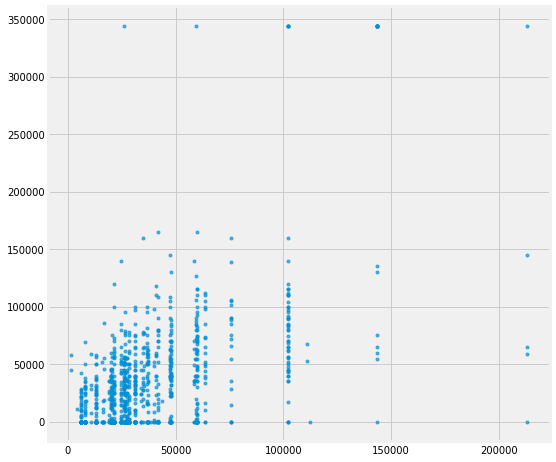

In [13]:
y_test_pred = grid_search.predict(x_test)

graph.figure(figsize=(8, 8))
graph.plot(y_test_pred, y_test, '.', alpha=0.66)
graph.show()

_Stephen Anthony Rose_